In [1]:
import torch
import matplotlib.pyplot as plt
from xitorch.optimize import rootfinder

from torchquad import Simpson, MonteCarlo, set_up_backend

import sys
sys.path.append('..')
from hijacobi import Task, Spherically_Symmetric, reparam


23:10:23|TQ-WARNING| Error enabling CUDA. cuda.is_available() returned False. CPU will be used.


In [3]:
def test_func(X, P):

    return X - P


In [4]:
P = torch.linspace(0, 5, 11)

X0 = - torch.ones_like(P)

res = rootfinder(test_func, X0, params = [P])

In [5]:
res

tensor([-1.1015e-08,  5.0000e-01,  1.0000e+00,  1.5000e+00,  2.0000e+00,
         2.5000e+00,  3.0000e+00,  3.5000e+00,  4.0000e+00,  4.5000e+00,
         5.0000e+00])

### Тест - решение уравнения на $r$-точку поворота, заданного вручную и из класса Model

- [ ] Passed

In [10]:
def f(r):
    return 1-2/r


def uR(r, l, q):
    
    return r**2*(r**2 - f(r)*(l**2 + q**2))


def uR_(r, l, q):

    outp = [uR(r_, l, q) for r_ in r]

    return torch.stack(outp)

BH0 = Spherically_Symmetric(f=f)

def uR_BH(r, l, q):

    return BH0.uR(r, l, q)

In [15]:
l_s = torch.linspace(-3, 3, 5)
q_s = torch.linspace(0, 5, 5)

l_grid, q_grid = torch.meshgrid(l_s, q_s, indexing='ij')

R0 = torch.ones_like(l_grid)

res_0 = rootfinder(uR, R0, params=[l_grid, q_grid])
res_1 = rootfinder(uR_BH, R0, params=[l_grid, q_grid])

c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\xitorch\_impls\optimize\root\rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 2600 iterations. Best |dx|=5.022e+00, |f|=4.514e+01 at iter 21
  warnings.warn(ConvergenceWarning(msg))


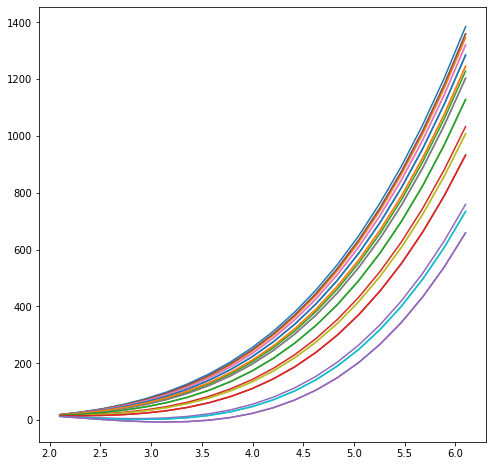

In [20]:
# проверим, есть ли вообще нули:

r_span = torch.linspace(2.1, 6.1, 20)

F = uR_(r_span, l_grid.flatten(), q_grid.flatten())

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(r_span, F)

plt.show()

In [16]:
print('Solutions match with tol 1e-1', torch.allclose(res_0, res_1, atol=1e-1))
print('Solutions match with tol 1e-3', torch.allclose(res_0, res_1, atol=1e-3))
print('Solutions match with tol 1e-5', torch.allclose(res_0, res_1, atol=1e-5))

zero = torch.zeros_like(R0)
print(uR(res_0, l_grid, q_grid))
print(uR_BH(res_1, l_grid, q_grid))

Solutions match with tol 1e-1 True
Solutions match with tol 1e-3 True
Solutions match with tol 1e-5 True
tensor([[ 5.3521,  8.3739, 11.2588, 15.6723, -0.2094],
        [ 2.4680,  3.1901,  9.2201, 15.9301,  2.9376],
        [ 1.5065,  2.8034,  9.0214, 15.6409,  5.6360],
        [ 2.4680,  3.1901,  9.2201, 15.9301,  2.9376],
        [ 5.3521,  8.3739, 11.2588, 15.6723, -0.2094]])
tensor([[ 5.3521,  8.3739, 11.2588, 15.6723, -0.2094],
        [ 2.4680,  3.1901,  9.2201, 15.9301,  2.9376],
        [ 1.5065,  2.8034,  9.0214, 15.6409,  5.6360],
        [ 2.4680,  3.1901,  9.2201, 15.9301,  2.9376],
        [ 5.3521,  8.3739, 11.2588, 15.6723, -0.2094]])


In [ ]:
# Нули есть, но их немного, и мы зацепили очень малое количество

## Пытаемся решать уравнения на интегралы...

In [25]:
int = Simpson()

def integrate_Ur(lims, l_s, q_s):

    dI = lambda r: torch.pow(uR_(r, l_s, q_s), -1/2)

    # domains = [torch.Tensor([[lims[i], lims[i+1]]]) for i in range(len(lims)-1)]

    # outp = [self.int.integrate(dI, dim=1, N=self.N, integration_domain=domain) for domain in domains]

    # return torch.sum(torch.stack(outp), dim=0)

    domain = torch.Tensor([[lims[0], lims[1]]])

    return int.integrate(dI, dim=1, N=31, integration_domain=domain)


In [26]:
# Проверяем интеграл
integrate_Ur([2.1, 22.1], l_grid, q_grid)

tensor([[0.4535, 0.4634, 0.4991, 0.5980,    nan],
        [0.4366, 0.4451, 0.4751, 0.5510, 1.0130],
        [0.4314, 0.4395, 0.4680, 0.5384, 0.8766],
        [0.4366, 0.4451, 0.4751, 0.5510, 1.0130],
        [0.4535, 0.4634, 0.4991, 0.5980,    nan]])

In [81]:
# Подтягиваем класс решателя и объявляем уравнения

Solver0 = reparam(BH0)
Solver0.set_Simpson()
Solver0.setup(2.4, 1e-4, 160, 31)
Solver0.setCustomIth(BH0.Ith)

eps = 0.44

eqA = lambda q, l: integrate_Ur([2.1, 22.1], l, q) - eps
eqB = lambda q, l: Solver0.integrate_Ur([2.1, 22.1], l, q) - eps

Test passed, setting fuction as Ith


In [36]:
l_s = torch.linspace(-2, 2, 11)
q_0 = torch.ones_like(l_s)

res_A = rootfinder(eqA, q_0, params=[l_s])
res_B = rootfinder(eqB, q_0, params=[l_s])

c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\xitorch\_impls\optimize\root\rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 1200 iterations. Best |dx|=1.752e+00, |f|=2.201e-02 at iter 3
  warnings.warn(ConvergenceWarning(msg))


In [38]:
print('Solution A: ', res_A)
print('err: ', eqA(l_s, res_A))

print('Solution B: ', res_B)
print('err: ', eqB(l_s, res_B))

Solution A:  tensor([-0.1654,  0.5126,  0.8407,  1.0011,  1.0741,  1.0951,  1.0741,  1.0011,
         0.8407,  0.5126, -0.1654])
err:  tensor([ 1.3639e-02,  6.5382e-03,  2.7356e-03, -2.3276e-05, -1.7840e-03,
        -2.3913e-03, -1.7840e-03, -2.3276e-05,  2.7356e-03,  6.5382e-03,
         1.3639e-02])
Solution B:  tensor([-0.1654,  0.5126,  0.8407,  1.0011,  1.0741,  1.0951,  1.0741,  1.0011,
         0.8407,  0.5126, -0.1654])
err:  tensor([ 1.3639e-02,  6.5382e-03,  2.7356e-03, -2.3276e-05, -1.7840e-03,
        -2.3913e-03, -1.7840e-03, -2.3276e-05,  2.7356e-03,  6.5382e-03,
         1.3639e-02])


Работает, теперь пробуем решить полноценное уравнение

### Решаем полноценное уравнение

In [89]:
def Ith(th, l_s, q_s):
    '''
    Precise exspression for 1/\sqrt(Uth) integral over interval 
    without turning points, if exists
    '''
    xi2 = (l_s/q_s)**2

    invmodulusLQ = torch.pow(l_s**2 + q_s**2, -0.5)

    if abs(th[0]) == torch.pi/2:
        outp0 = torch.zeros_like(q_s)
    else:
        tanth = torch.tan(th[0])
        arg = torch.sqrt((1+xi2)/(tanth**2-xi2))*torch.sign(tanth)
        outp0 = -invmodulusLQ*torch.atan(arg)

    if abs(th[1]) == torch.pi/2:
        outp1 = torch.zeros_like(q_s)
    else:
        tanth = torch.tan(th[1])
        arg = torch.sqrt((1+xi2)/(tanth**2-xi2))*torch.sign(tanth)
        outp1 = -invmodulusLQ*torch.atan(arg)
    
    return (outp1 - outp0)

In [90]:
r_lims = [2.1, 12.1]
th_lims = torch.Tensor([1.4, 0.8])

eqA = lambda l, q: integrate_Ur(r_lims, l, q) + Ith(th_lims, l, q)

In [91]:
l_s = torch.linspace(-2, 2, 11)
q_0 = torch.ones_like(l_s)*3

print(BH0.Ith(th_lims, l_s, q_0))
print(integrate_Ur(r_lims, l_s, q_0))


tensor([-0.2182, -0.2107, -0.2057, -0.2024, -0.2006, -0.2000, -0.2006, -0.2024,
        -0.2057, -0.2107, -0.2182])
tensor([0.4884, 0.4736, 0.4632, 0.4562, 0.4522, 0.4509, 0.4522, 0.4562, 0.4632,
        0.4736, 0.4884])


In [92]:
l_s = torch.linspace(-2, 2, 1)
q_0 = torch.ones_like(l_s)*2

res_A = rootfinder(eqA, l_s, params=[q_0], maxiter=120)

print('Solution A: ', res_A)
print('err: ', eqA(res_A, q_0))

Solution A:  tensor([-2.])
err:  tensor([0.0342])


c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\xitorch\_impls\optimize\root\rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 120 iterations. Best |dx|=2.000e+00, |f|=3.422e-02 at iter 0
  warnings.warn(ConvergenceWarning(msg))


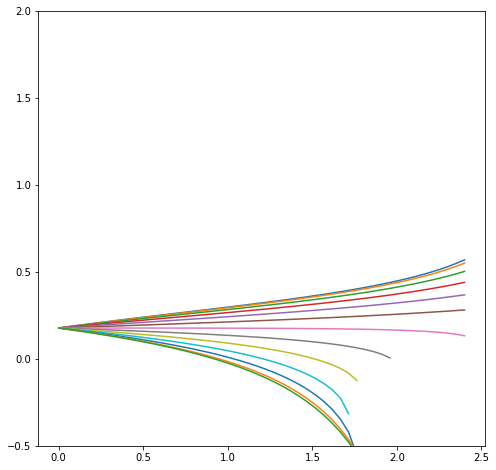

In [105]:
lX = lambda p, gma: p*torch.sin(gma)
qX = lambda p, gma: 2.4 + p*torch.cos(gma)

r_lims = [2.1, 12.1]
th_lims = torch.Tensor([1.4, 0.8])
eqA = lambda l, q: integrate_Ur(r_lims, l, q) + Ith(th_lims, l, q)

p_s = torch.linspace(0, 2.4, 50) 
gma_s = torch.linspace(0, 1, 13)*torch.pi

p_grid, gma_grid = torch.meshgrid(p_s, gma_s, indexing='ij')

F = eqA(lX(p_grid, gma_grid), qX(p_grid, gma_grid))

fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.plot(p_s, F)
ax.set_ylim(-0.5, 2)
plt.show()

In [94]:
lX = lambda p, gma: p*torch.sin(gma)
qX = lambda p, gma: 2.4 + p*torch.cos(gma)

gma = torch.linspace(0, 1, 13)*torch.pi
p0 = torch.ones_like(gma)*2

eq_p = lambda p, gma: eqA(lX(p, gma), qX(p, gma))

res_p = rootfinder(eq_p, p0, params=[gma])

c:\Users\aleks\AppData\Local\Programs\Python\Python310\lib\site-packages\xitorch\_impls\optimize\root\rootsolver.py:165: ConvergenceWarning: The rootfinder does not converge after 1400 iterations. Best |dx|=7.211e+00, |f|=nan at iter 0
  warnings.warn(ConvergenceWarning(msg))


In [95]:
res_p

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.])

In [149]:
def bisection(func: callable, x_min: torch.Tensor, x_max: torch.Tensor, par: torch.Tensor, tol=1e-4, maxiter=100):
    '''
    eq: callable X
    intervals: intervals[0] must be x_min, intervals[1] must be x_max
    '''
    mid = (x_min+x_max)/2

    if maxiter==0:

        return mid

    else:
        
        f_mid = func(mid, par)

        tol_mask = torch.greater(abs(f_mid), tol)
        
        sign0 = torch.greater(func(x_min, par), 0)
        sign1 = torch.greater(func(x_max, par), 0)

        # mask0 = torch.logical_xor(sign0, sign1)

        mask0 = torch.logical_and(torch.logical_xor(sign0, sign1), tol_mask)

        mid0 = mid[mask0]

        sign_mid = torch.greater(f_mid[mask0], 0)

        mask_mid = torch.logical_xor(sign0[mask0], sign_mid)
        not_mask_mid = torch.logical_not(mask_mid)

        new_xmin = x_min[mask0]
        new_xmax = x_max[mask0]

        new_xmax[mask_mid] = mid0[mask_mid]
        new_xmin[not_mask_mid] = mid0[not_mask_mid]

        res = bisection(func, new_xmax, new_xmin, par[mask0], tol=tol, maxiter=maxiter-1)

        outp = mid

        outp[mask0] = res

        return outp


In [154]:
eq_p = lambda p, gma: eqA(lX(p, gma), qX(p, gma))

par = torch.linspace(0, 1, 25)*torch.pi
pmin = -torch.ones_like(par)*0.1
pmax = torch.ones_like(par)*1.6

pres = bisection(eq_p, pmin, pmax, par, tol=1e-7, maxiter=20)

print('Err: ', eq_p(pres, par))

Err:  tensor([ 2.6817e-01,  2.6749e-01,  2.6544e-01,  2.6203e-01,  2.5730e-01,
         2.5127e-01,  2.4397e-01,  2.3545e-01,  2.2576e-01,  2.1495e-01,
         2.0310e-01,  1.9029e-01,  1.7664e-01,  1.6231e-01,  1.4749e-01,
         1.3243e-01,  0.0000e+00, -5.9605e-08, -8.9407e-08,  1.1921e-07,
         8.9407e-08,  1.1921e-07, -2.9802e-08,  0.0000e+00,  5.9605e-08])


In [152]:
test_fun = lambda X, P: X - P

par = torch.linspace(-0.5, 0.5, 11)
xmin = -torch.ones_like(par)
xmax = torch.ones_like(par)

bisection(test_fun, xmin, xmax, par, tol=1e-8, maxiter=20)

tensor([-0.5000, -0.4000, -0.3000, -0.2000, -0.1000,  0.0000,  0.1000,  0.2000,
         0.3000,  0.4000,  0.5000])